In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE,RFECV,SelectKBest
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
import seaborn as sns
import matplotlib.pyplot as plt

from cycifsuite.get_data import read_synapse_file
from rfpimp import importances
%load_ext autoreload
%autoreload 2

In [2]:
def data_preprocessing(path, fname, ligand_name=None, sample_size=None, excluding_cells=[]):
    '''Read data and construct
    '''
    os.chdir(path)
    imputer = SimpleImputer(strategy='median')
    x = pd.read_hdf(fname)
    zero_std_cols = x.columns[x.std() == 0]
    x = x.drop(zero_std_cols, axis=1)
    x.loc[:, :] = imputer.fit_transform(x)

    # Sampling easier feature selection
    if sample_size is not None:
        if isinstance(sample_size, float):
            sample_size = int(sample_size * x.shape[0])
        elif isinstance(sample_size, int):
            pass
        # get rid of cells not wanted
        sample_pool = [k for k in x.index if k not in excluding_cells]
        sample_idx = np.random.choice(
            x.index, size=sample_size)
        x = x.loc[sample_idx]
    # make y_vector
    y_vector = None
    if ligand_name is not None:
        y_vector = [ligand_name] * x.shape[0]
    return x, y_vector

In [3]:
path = 'd:/data/MCF10A 090718 data/'
os.chdir(path)
feature_files = [x for x in os.listdir() if '_txt' in x]
pooled_metadata = pd.read_csv(read_synapse_file('syn17902177'),index_col=0)
print(feature_files)

Welcome, Yunguan Wang!

['plate_6_txt_features_all.hdf', 'plate_6_txt_features_BMP2.hdf', 'plate_6_txt_features_EGF.hdf', 'plate_6_txt_features_HGF.hdf', 'plate_6_txt_features_IFNG.hdf', 'plate_6_txt_features_OSM.hdf', 'plate_6_txt_features_PBS.hdf', 'plate_6_txt_features_TGFB.hdf']


# Getting some simple stats on data, e.g., std, cv
## Since Anova is fast, ran it on all data instead of sampled data

# Read and bin the data well-wise
### Note: Scaling for PCA

In [4]:
x_binned = pd.DataFrame()
y = []
for fn in feature_files[1:]:
    ligand = fn.split('_')[-1][:-4]
    _x, _y = data_preprocessing(path,fn,ligand_name=ligand)
    cm_cells = [k for k in _x.index if k in pooled_metadata.index]
    _x = _x.loc[cm_cells].groupby(pooled_metadata.loc[cm_cells,'Well']).median()
    if x_binned.shape[0]==0:
        x_binned = _x
    else:
        cols = [k for k in x_binned.columns if k in _x.columns]
        _x = _x[cols]
        x_binned = x_binned[cols].append(_x[cols])
    y += [ligand]*_x.shape[0]
# scaling
y_binned = y
x_scale = x_binned.copy()
x_scale.loc[:,:] = minmax_scale(x_scale)

## Read full data just for anova

In [5]:
x = pd.DataFrame()
y = []
for fn in feature_files[1:]:
    ligand = fn.split('_')[-1][:-4]
    _x, _y = data_preprocessing(path,fn,ligand_name=ligand)
    if x.shape[0]==0:
        x = _x
    else:
        cols = [k for k in x.columns if k in _x.columns]
        x = x[cols].append(_x[cols])
    y+=_y
x.loc[:,:] = minmax_scale(x)

## Figure 1A std histogram and 1B ANOVA

Text(0.5, 1.0, 'ANOVA F scores across all samples')

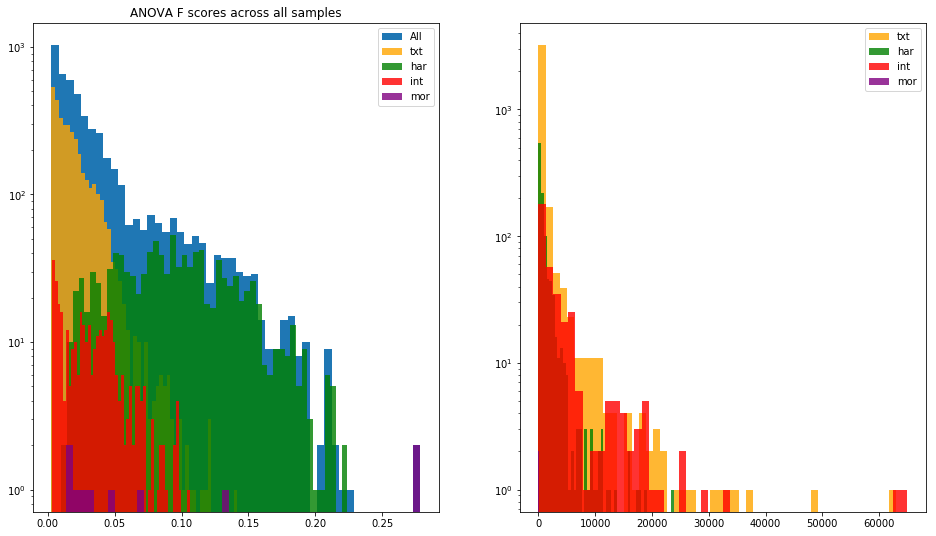

In [6]:
# Anova
sk = SelectKBest(k=x.shape[1])
sk.fit(x,y)
sk_fs = sk.get_support()
sk_fs = x.columns[sk_fs]

all_features = x.columns
_, axes = plt.subplots(ncols=2, figsize=(16,9))
axes = axes.ravel()
axes[0].hist(x.std(),bins=50, label='All')
for feature_type,c in zip(['_txt_','_har_','_int_','mor'],['orange','g','red','purple']):
    feature_list = [k for k in all_features if feature_type in k]
    axes[0].hist(x[feature_list].std(), bins=50, label=feature_type.replace('_',''),alpha=0.8,color=c)
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_title('Distribution of std across all samples')

anova = pd.Series(sk.scores_, index=x.columns)
for feature_type,c in zip(['_txt_','_har_','_int_','mor'],['orange','g','red','purple']):
    feature_list = [k for k in all_features if feature_type in k]
    axes[1].hist(anova[feature_list], bins=50,label=feature_type.replace('_',''),alpha=0.8,color=c)
axes[1].legend()
# axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[0].set_title('ANOVA F scores across all samples')

# PCA to test if the centroids are separable

array([0.36026834, 0.25624167])

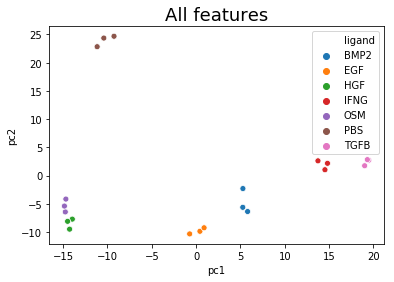

In [7]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
pca=PCA(2)
pca_x = pca.fit_transform(x_scale)
pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
pca_x['ligand'] = y_binned
sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand')
plt.title('All features', fontsize=18)
pca.explained_variance_ratio_

# Repeat the previous analysis using each feature category
### Figure 2

Number of _txt_ features : 3596
Number of _har_ features : 1080
Number of _int_ features : 360
Number of mor features : 10
Total number of these categories: 5046 out of total of 5046


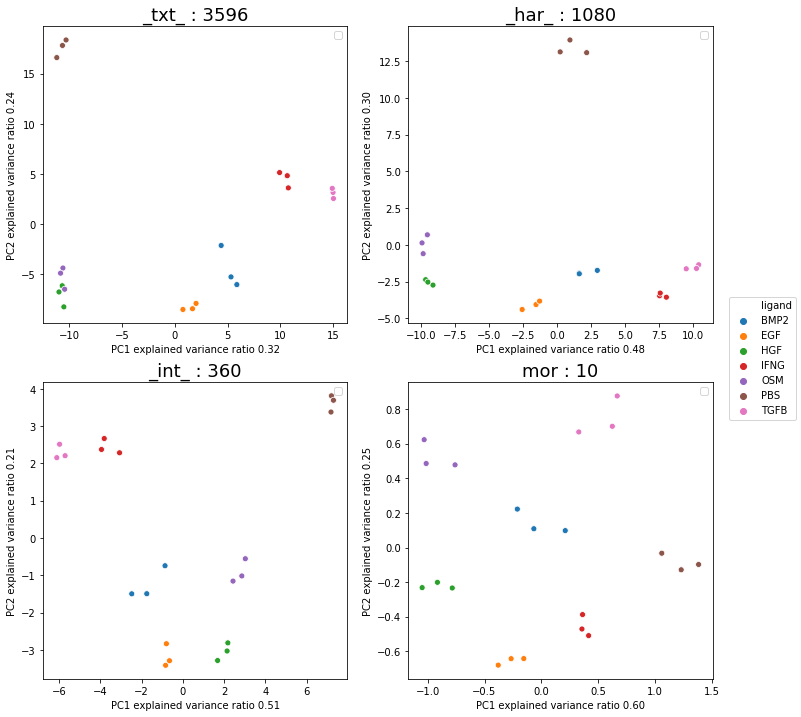

In [8]:
# Get feature stats
all_featuers  = x_scale.columns
txt_features = [k for k in all_featuers if '_txt_' in k]
har_features = [k for k in all_featuers if '_har_' in k]
int_features = [k for k in all_featuers if '_int_' in k]
mor_features = [k for k in all_featuers if 'mor' in k]
sum_features=0
for feature_type in ['_txt_','_har_','_int_','mor']:
    feature_list = [k for k in all_featuers if feature_type in k]
    num_features = len(feature_list)
    print('Number of {} features : {}'.format(feature_type, num_features))
    sum_features+=num_features
print('Total number of these categories: {} out of total of {}'.format(sum_features, len(all_featuers)))

# PCA plots of each feature category
fig, axes = plt.subplots(2,2, figsize=(12,12))
axes = axes.ravel()
i=0
for feature_type in ['_txt_','_har_','_int_','mor']:
    feature_list = [k for k in all_featuers if feature_type in k]
    num_features = len(feature_list)
    pca=PCA(2)
    pca_x = pca.fit_transform(x_scale[feature_list])
    pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
    pca_x['ligand'] = sorted(y_binned)
    g = sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand', ax = axes[i])
    if i==0:
        lgd_handles, lgd_labels = g.get_legend_handles_labels()
    g.set_title('{} : {}'.format(feature_type,num_features), fontsize=18)
    g.legend('')
    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    g.set_xlabel('PC1 explained variance ratio {:.2f}'.format(pc1))
    g.set_ylabel('PC2 explained variance ratio {:.2f}'.format(pc2))
    i+=1
fig.legend(lgd_handles, lgd_labels,loc='center right')

## Evaluate full model and models with different cat of features

In [9]:
x = pd.DataFrame()
y = []
for fn in feature_files[1:]:
    ligand = fn.split('_')[-1][:-4]
    _x, _y = data_preprocessing(path,fn,ligand_name=ligand, sample_size=1500)
    if x.shape[0]==0:
        x = _x
    else:
        cols = [k for k in x.columns if k in _x.columns]
        x = x[cols].append(_x[cols])
    y+=_y
x.loc[:,:] = minmax_scale(x)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.20)
print(x_train.shape)
full_model = RandomForestClassifier(100)
full_model.fit(x_train, y_train)
y_pred = full_model.predict(x_test)
print('Full feature accuracy {}'.format(acc(y_test, y_pred)))

(8400, 5046)
Full feature accuracy 0.9619047619047619


In [10]:
cat_model = RandomForestClassifier(100)
model_stats = pd.DataFrame()
for feature_type in ['_txt_','_har_','_int_','mor']:
    feature_list = [k for k in all_featuers if feature_type in k]
    rf_cv = cross_val_score(cat_model, x_train[feature_list], y_train,scoring='accuracy', cv=10,n_jobs=4)
    model_stats.loc['mean',feature_type] = rf_cv.mean()
    model_stats.loc['sd',feature_type] = rf_cv.std()
    print('CV accurary with feature category {}: {:.2f}'.format(feature_type, rf_cv.mean()))

CV accurary with feature category _txt_: 0.95
CV accurary with feature category _har_: 0.83
CV accurary with feature category _int_: 0.94
CV accurary with feature category mor: 0.31


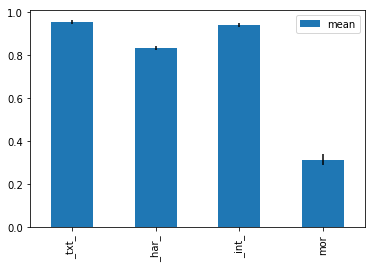

In [11]:
model_stats.transpose().plot(kind='bar',yerr='sd')

## It is now very clear the morphology features performs terribly on their own.
### Why they looked so good on PCA plot? 
### Remember the assumption before doing binning based PCA, which is high hemogeneity in data.

### Evaluate the single cell level data on morphology feature. (10% sampled data)

Text(0.5, 1.0, '10 morphology feature')

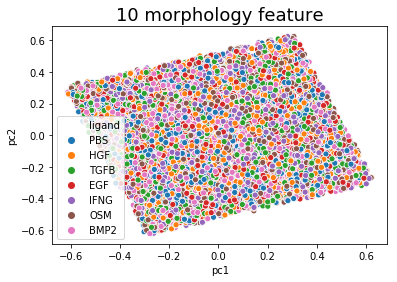

In [12]:
pca=PCA(2)
pca_x = pca.fit_transform(x_train[feature_list])
pca_x = pd.DataFrame(pca_x, columns=['pc1','pc2'])
pca_x['ligand'] = y_train
sns.scatterplot('pc1','pc2',data=pca_x,hue='ligand')
plt.title('10 morphology feature', fontsize=18)